<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-TensorFlow/blob/main/Univariate-Time-Series-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Loading the dataset

In [2]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/TirendazAcademy/Deep-Learning-with-TensorFlow/raw/main/Data/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

# Data preprocessing

In [3]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


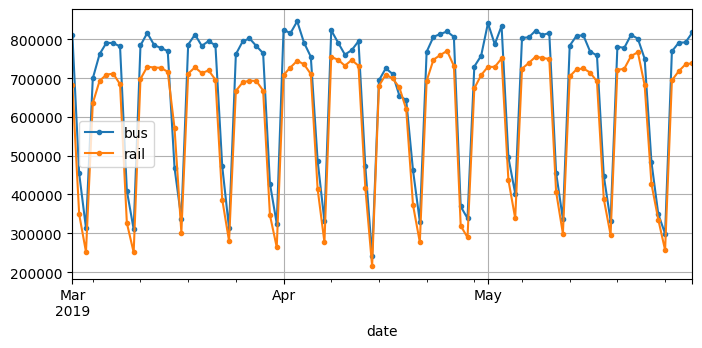

In [5]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

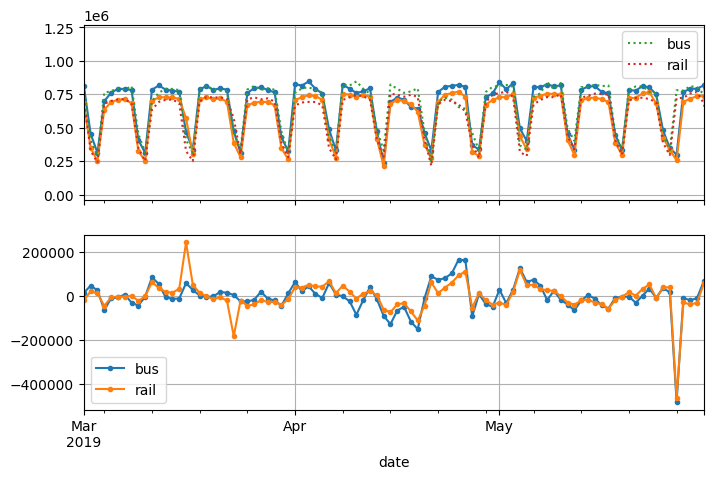

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")

df.shift(7).plot(ax=axs[0], grid=True, legend=True, linestyle=":")

diff_7.plot(ax=axs[1], grid=True, marker=".")
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

# Model 1: Naive approach

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]

In [10]:
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [11]:
period = slice("2001", "2019")
period

slice('2001', '2019', None)

<ipython-input-12-c57bfc7013ea>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').mean()  # compute the mean for each month


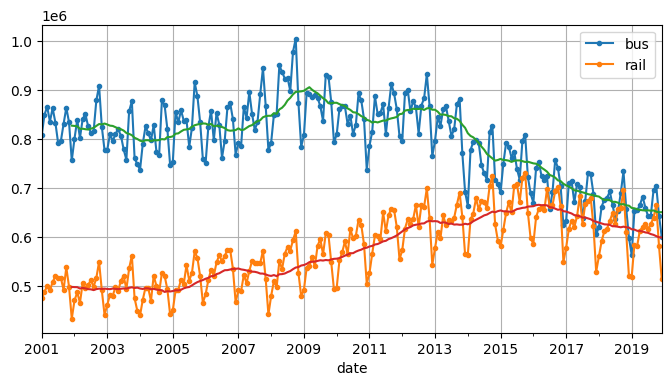

In [12]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

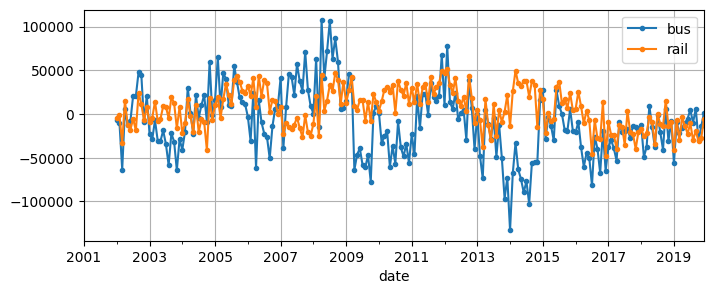

In [13]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

# Data loading with Keras

In [14]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [15]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# Model 2: Regression

In [16]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=100,
                    callbacks=[early_stopping_cb])

Epoch 1/100
33/33 [==============================] - 1s 9ms/step - loss: 0.0272 - mae: 0.1829 - val_loss: 0.0099 - val_mae: 0.1074
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0084 - mae: 0.0966 - val_loss: 0.0073 - val_mae: 0.0910
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0079 - mae: 0.0941 - val_loss: 0.0066 - val_mae: 0.0844
Epoch 4/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0069 - mae: 0.0846 - val_loss: 0.0061 - val_mae: 0.0802
Epoch 5/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0062 - mae: 0.0806 - val_loss: 0.0058 - val_mae: 0.0758
Epoch 6/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0061 - mae: 0.0794 - val_loss: 0.0053 - val_mae: 0.0726
Epoch 7/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0054 - mae: 0.0738 - val_loss: 0.0051 - val_mae: 0.0697
Epoch 8/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0052 -

In [17]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 6ms/step - loss: 0.0021 - mae: 0.0374


37356.71937465668

# Model 3: Simple RNN

In [18]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [19]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [20]:
fit_and_evaluate(univar_model, train_ds, valid_ds, epochs=100, learning_rate=0.02)

Epoch 1/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0111 - mae: 0.1166 - val_loss: 0.0051 - val_mae: 0.0745
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0055 - mae: 0.0735 - val_loss: 0.0032 - val_mae: 0.0562
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0044 - mae: 0.0656 - val_loss: 0.0026 - val_mae: 0.0485
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0038 - mae: 0.0583 - val_loss: 0.0026 - val_mae: 0.0497
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0034 - mae: 0.0515 - val_loss: 0.0021 - val_mae: 0.0396
Epoch 6/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0034 - mae: 0.0525 - val_loss: 0.0020 - val_mae: 0.0354
Epoch 7/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0034 - mae: 0.0526 - val_loss: 0.0020 - val_mae: 0.0352
Epoch 8/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0

33894.263207912445

# Model 4: Deep RNNs

In [21]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [22]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 3s 32ms/step - loss: 0.0154 - mae: 0.1366 - val_loss: 0.0078 - val_mae: 0.1039
Epoch 2/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0061 - mae: 0.0797 - val_loss: 0.0025 - val_mae: 0.0477
Epoch 3/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0042 - mae: 0.0603 - val_loss: 0.0023 - val_mae: 0.0414
Epoch 4/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0048 - mae: 0.0673 - val_loss: 0.0039 - val_mae: 0.0674
Epoch 5/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0043 - mae: 0.0624 - val_loss: 0.0022 - val_mae: 0.0407
Epoch 6/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0036 - mae: 0.0546 - val_loss: 0.0021 - val_mae: 0.0373
Epoch 7/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0036 - mae: 0.0543 - val_loss: 0.0024 - val_mae: 0.0429
Epoch 8/500
33/33 [==============================] - 1s 23ms/step - loss: 0.

30047.15032875538

# Model 5: LSTM

In [23]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [24]:
fit_and_evaluate(lstm_model, train_ds, valid_ds, learning_rate=0.01, epochs=20)

Epoch 1/20
33/33 [==============================] - 2s 32ms/step - loss: 0.0641 - mae: 0.2773 - val_loss: 0.0206 - val_mae: 0.1924
Epoch 2/20
33/33 [==============================] - 1s 28ms/step - loss: 0.0194 - mae: 0.1691 - val_loss: 0.0173 - val_mae: 0.1488
Epoch 3/20
33/33 [==============================] - 1s 19ms/step - loss: 0.0180 - mae: 0.1649 - val_loss: 0.0175 - val_mae: 0.1419
Epoch 4/20
33/33 [==============================] - 1s 20ms/step - loss: 0.0180 - mae: 0.1636 - val_loss: 0.0177 - val_mae: 0.1384
Epoch 5/20
33/33 [==============================] - 1s 20ms/step - loss: 0.0177 - mae: 0.1629 - val_loss: 0.0170 - val_mae: 0.1441
Epoch 6/20
33/33 [==============================] - 1s 19ms/step - loss: 0.0175 - mae: 0.1623 - val_loss: 0.0170 - val_mae: 0.1425
Epoch 7/20
33/33 [==============================] - 1s 20ms/step - loss: 0.0174 - mae: 0.1620 - val_loss: 0.0168 - val_mae: 0.1430
Epoch 8/20
33/33 [==============================] - 1s 19ms/step - loss: 0.0173 - m

133096.66514396667

# Model 6: GRU

In [25]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [26]:
fit_and_evaluate(gru_model, train_ds, valid_ds, learning_rate=0.01, epochs=20)

Epoch 1/20
33/33 [==============================] - 2s 30ms/step - loss: 0.0311 - mae: 0.2033 - val_loss: 0.0184 - val_mae: 0.1656
Epoch 2/20
33/33 [==============================] - 1s 20ms/step - loss: 0.0192 - mae: 0.1632 - val_loss: 0.0182 - val_mae: 0.1479
Epoch 3/20
33/33 [==============================] - 1s 22ms/step - loss: 0.0187 - mae: 0.1636 - val_loss: 0.0179 - val_mae: 0.1463
Epoch 4/20
33/33 [==============================] - 1s 28ms/step - loss: 0.0185 - mae: 0.1625 - val_loss: 0.0174 - val_mae: 0.1504
Epoch 5/20
33/33 [==============================] - 1s 25ms/step - loss: 0.0182 - mae: 0.1621 - val_loss: 0.0173 - val_mae: 0.1476
Epoch 6/20
33/33 [==============================] - 1s 22ms/step - loss: 0.0181 - mae: 0.1645 - val_loss: 0.0169 - val_mae: 0.1542
Epoch 7/20
33/33 [==============================] - 1s 21ms/step - loss: 0.0178 - mae: 0.1632 - val_loss: 0.0168 - val_mae: 0.1497
Epoch 8/20
33/33 [==============================] - 1s 21ms/step - loss: 0.0176 - m

143289.02959823608

## Resources:

- [Hands-on ML with Scikit-Learn & TensorFlow](https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb)

Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) | [GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎